In [1]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt

# Load CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1]
y_train, y_test = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)

In [2]:
def resnet_block(x, filters, strides=1):
    # Shortcut
    shortcut = x
    if strides > 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Residual Path
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Add Residual Connection
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

def build_resnet50(input_shape=(32, 32, 3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=2, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((3, 3), strides=2, padding="same")(x)

    # Add Residual Blocks
    for filters, blocks, strides in [(64, 3, 1), (128, 4, 2), (256, 6, 2), (512, 3, 2)]:
        for i in range(blocks):
            x = resnet_block(x, filters, strides if i == 0 else 1)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inputs, outputs)


In [3]:
def resnet_block_no_skip(x, filters, strides=1):
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def build_no_skip_resnet50(input_shape=(32, 32, 3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=2, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((3, 3), strides=2, padding="same")(x)

    # Add Blocks Without Skip Connections
    for filters, blocks, strides in [(64, 3, 1), (128, 4, 2), (256, 6, 2), (512, 3, 2)]:
        for i in range(blocks):
            x = resnet_block_no_skip(x, filters, strides if i == 0 else 1)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inputs, outputs)

In [4]:
resnet50 = build_resnet50(num_classes=100)
no_skip_resnet50 = build_no_skip_resnet50(num_classes=100)

In [5]:
# Compile the Models
resnet50.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
no_skip_resnet50.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [6]:
# Train ResNet50 with Skip Connections
history_resnet = resnet50.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=64
)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 37ms/step - accuracy: 0.0626 - loss: 4.4417 - val_accuracy: 0.0323 - val_loss: 8.1034
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.1296 - loss: 3.7659 - val_accuracy: 0.0627 - val_loss: 4.5076
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.1722 - loss: 3.5339 - val_accuracy: 0.0861 - val_loss: 6.7313
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.2183 - loss: 3.2750 - val_accuracy: 0.1110 - val_loss: 4.5034
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.2387 - loss: 3.1164 - val_accuracy: 0.1610 - val_loss: 3.7917
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.2947 - loss: 2.8212 - val_accuracy: 0.2798 - val_loss: 2.9052
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3083 - loss: 2.7736 - val_accuracy: 0.1157 - val_loss: 121.6273
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3253 - loss: 2.6787 

In [7]:
# Train Custom Model Without Skip Connections
history_no_skip = no_skip_resnet50.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=64
)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 29ms/step - accuracy: 0.0333 - loss: 4.6639 - val_accuracy: 0.0559 - val_loss: 4.7794
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.0628 - loss: 4.1249 - val_accuracy: 0.0316 - val_loss: 6.4084
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.0760 - loss: 4.0328 - val_accuracy: 0.0596 - val_loss: 5.2640
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.0839 - loss: 3.9815 - val_accuracy: 0.0446 - val_loss: 5.7102
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.0827 - loss: 3.9749 - val_accuracy: 0.0564 - val_loss: 4.3289
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1130 - loss: 3.7478 - val_accuracy: 0.0245 - val_loss: 10.1957
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1180 - loss: 3.7104 - val_accuracy: 0.0464 - val_loss: 7.2439
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1333 - loss: 3.5999 - val_ac

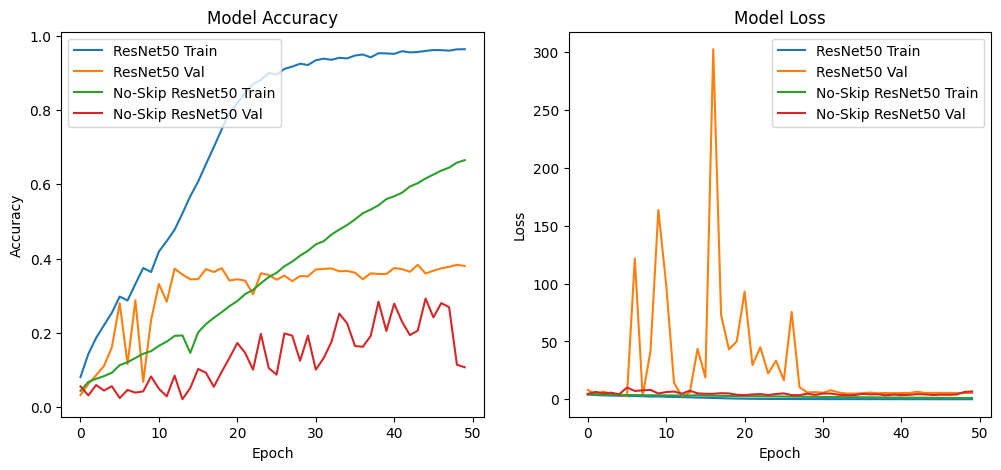

In [8]:
# Plot Training and Validation Results
def plot_comparison(history1, history2, label1, label2):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history["accuracy"], label=f"{label1} Train")
    plt.plot(history1.history["val_accuracy"], label=f"{label1} Val")
    plt.plot(history2.history["accuracy"], label=f"{label2} Train")
    plt.plot(history2.history["val_accuracy"], label=f"{label2} Val")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history["loss"], label=f"{label1} Train")
    plt.plot(history1.history["val_loss"], label=f"{label1} Val")
    plt.plot(history2.history["loss"], label=f"{label2} Train")
    plt.plot(history2.history["val_loss"], label=f"{label2} Val")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_comparison(history_resnet, history_no_skip, "ResNet50", "No-Skip ResNet50")